# COURSE: A deep understanding of deep learning
## SECTION: Understand and design CNNs
### LECTURE: The EMNIST dataset (letter recognition)
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/dudl/?couponCode=202111

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [3]:
# download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist',split='letters',download=True)

# more info: https://www.nist.gov/itl/products-and-services/emnist-dataset

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [4]:
# inspect the data

# the categories (but how many letters??)
print(cdata.classes)
print(str(len(cdata.classes)) + ' classes')

print('\nData size:')
print(cdata.data.shape)

# transform to 4D tensor for conv layers (and transform from int8 to float)
images_L = cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images_L.shape)


['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])


In [5]:
# brief aside: class 'N/A' doesn't exist in the data.
print( torch.sum(cdata.targets==0) )

# However, it causes problems in one-hot encoding...
torch.unique(cdata.targets)

tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [6]:
# so therefore we'll eliminate it and subtract 1 from the original

# remove the first class category
letterCategories = cdata.classes[1:]

# relabel labels to start at 0
labels_L = copy.deepcopy(cdata.targets)-1
print(labels_L.shape)

### 
print( torch.sum(labels_L==0) )
torch.unique(labels_L)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

# Create train/test groups using DataLoader

In [7]:
# Step 2: use scikitlearn to split the data
train_data_L,test_data_L, train_labels_L,test_labels_L = train_test_split(images_L, labels_L, test_size=.1)

# Step 3: convert into PyTorch Datasets
train_data_L = TensorDataset(train_data_L,train_labels_L)
test_data_L  = TensorDataset(test_data_L,test_labels_L)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader_L = DataLoader(train_data_L,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader_L  = DataLoader(test_data_L,batch_size=test_data_L.tensors[0].shape[0])

In [8]:
# check size (should be images X channels X width X height
print( train_loader_L.dataset.tensors[0].shape )
print( train_loader_L.dataset.tensors[1].shape )

torch.Size([112320, 1, 28, 28])
torch.Size([112320])


# Import the digits

In [17]:
# import dataset (comes with colab!)
data_D = torchvision.datasets.EMNIST(root='emnist',split='digits',download=True)


In [18]:
### transformations on numbers data

# transform to 4D tensor for conv layers (and transform from int8 to float)
images_D = data_D.data.view([data_D.data.shape[0],1,28,28]).float()
images_D /= torch.max(images_D)


# split the images and convert to dataloaders
train_data_D,test_data_D, train_labels_D,test_labels_D = train_test_split(images_D, data_D.targets, test_size=.1)

# convert into PyTorch Datasets
train_data_D = torch.utils.data.TensorDataset(train_data_D,train_labels_D)
test_data_D  = torch.utils.data.TensorDataset(test_data_D,test_labels_D)

# translate into dataloader objects
batchsize = 32
train_loader_D = DataLoader(train_data_D,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader_D = DataLoader(test_data_D,batch_size=test_data_D.tensors[0].shape[0])

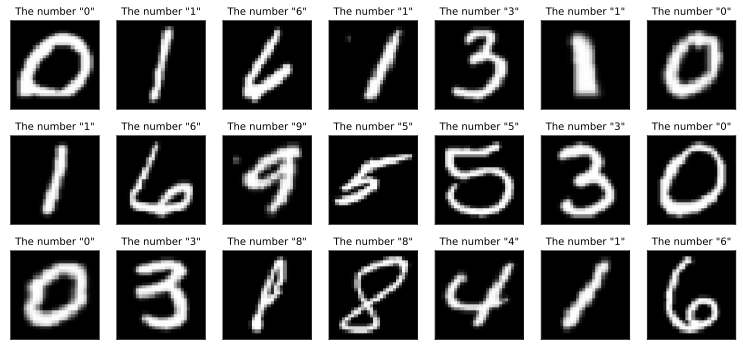

In [19]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(train_loader_D))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

Transform the model in order to accommodate 'letter' and 'digits' mode

In [20]:
# create a class for the model
def makeTheNet(printtoggle=False):

  class emnistnet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()
      
      # print toggle
      self.print = printtoggle

      ### -------------- feature map layers -------------- ###
      # first convolution layer
      self.conv1  = nn.Conv2d(1,6,3,padding=1)
      self.bnorm1 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (28+2*1-3)/1 + 1 = 28/2 = 14 (/2 b/c maxpool)

      # second convolution layer
      self.conv2  = nn.Conv2d(6,6,3,padding=1)
      self.bnorm2 = nn.BatchNorm2d(6) # input the number of channels in this layer
      # output size: (14+2*1-3)/1 + 1 = 14/2 = 7 (/2 b/c maxpool)

      
      ### -------------- linear decision layers -------------- ###
      self.fc1 = nn.Linear(7*7*6,50)

      self.fc2 = nn.Linear(50,26)


    def forward(self,x):
      
      if self.print: print(f'Input: {list(x.shape)}')
      
      # first block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv1(x),2)
      x = F.leaky_relu(self.bnorm1(x))
      if self.print: print(f'First CPR block: {list(x.shape)}')

      # second block: convolution -> maxpool -> batchnorm -> relu
      x = F.max_pool2d(self.conv2(x),2)
      x = F.leaky_relu(self.bnorm2(x))
      if self.print: print(f'Second CPR block: {list(x.shape)}')

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorized: {list(x.shape)}')
      
      # linear layers
      x = F.leaky_relu(self.fc1(x))
      x = self.fc2(x)
      if self.print: print(f'Final output: {list(x.shape)}')

      return x

  # create the model instance
  net = emnistnet(printtoggle)
  
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [21]:
# test the model with one batch
net,lossfun,optimizer = makeTheNet(False)

X,y = iter(train_loader_L).next()
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# # now let's compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)


Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2508, grad_fn=<NllLossBackward0>)


# Create a function that trains the model

In [39]:
# a function that trains the model

def function2trainTheModel(net,optimizer,train_loader,test_loader,numepochs=10,freeze = 'off'):

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)
  trainErr  = torch.zeros(numepochs)
  testErr   = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):
    
    if freeze == 'on':
      print('layers will be frozen')
      for p in net.named_parameters():
        if 'fc2' not in p[0]:
          p[1].requires_grad = False

    # loop over training data batches
    net.train()
    batchLoss = []
    batchErr  = []



    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())
      batchErr.append( torch.mean((torch.argmax(yHat,axis=1) != y).float()).item() )
    # end of batch loop...

    # and get average losses and error rates across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainErr[epochi]  = 100*np.mean(batchErr)



    ### test performance
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      loss = lossfun(yHat,y)
      
    # get loss and error rate from the test batch
    testLoss[epochi] = loss.item()
    testErr[epochi]  = 100*torch.mean((torch.argmax(yHat,axis=1) != y).float()).item()

  # end epochs

  # function output
  return trainLoss,testLoss,trainErr,testErr,net

# Run the model and show the results!

In [45]:
# ~2 minutes with 10 epochs on GPU (8 mins on the CPU!)
letterNet,lossfun,optimizer = makeTheNet()

trainLoss,testLoss,trainErr,testErr,letterNet = function2trainTheModel(
                                                letterNet,optimizer,train_loader_L,test_loader_L,5)

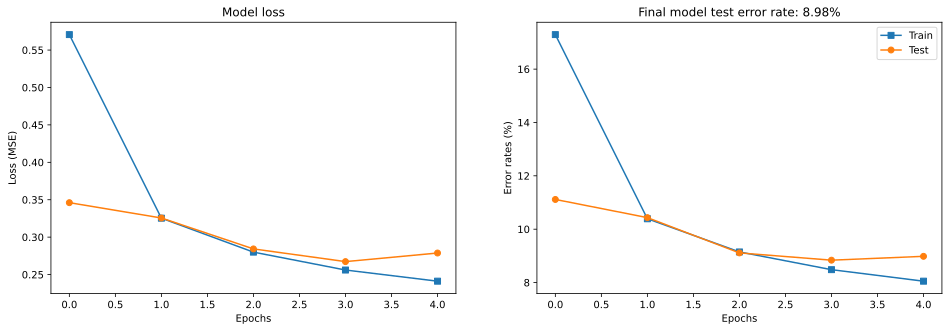

In [24]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr,'s-',label='Train')
ax[1].plot(testErr,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [46]:
# create the target model
numberNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(numberNet.named_parameters(),letterNet.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

In [51]:
# check out the network
print(numberNet)
print(' ')

# and the final layer
print(numberNet.fc2)

# replace the final layer to have 10 outputs instead of 26
numberNet.fc2 = nn.Linear(50,10)

# and check it again
print(' ')
print(numberNet)

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
)
 
Linear(in_features=50, out_features=26, bias=True)
 
emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [48]:
trainLoss,testLoss,trainErr,testErr,numberNet = function2trainTheModel(
                                                   numberNet,optimizer,train_loader_D,test_loader_D,1)

trainLoss_D,testLoss_D,trainErr_D,testErr_D,DigitNet = function2trainTheModel(
                                         DigitNet,optimizer,train_loader_D,test_loader_D,numepochs = 1)

In [49]:
print(f'numberNet TRAIN error rate: {trainErr[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr[-1]:.2f}%')

numberNet TRAIN error rate: 2.75%
numberNet TEST error rate: 1.31%


In [50]:
# create the target model
DigitNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(DigitNet.named_parameters(),net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

DigitFreezeNet,lossfun,optimizer = makeTheNet()

# then replace all the weights in TARGET model from SOURCE model
for target,source in zip(DigitNet.named_parameters(),net.named_parameters()):
  target[1].data = copy.deepcopy( source[1].data )

DigitNet.fc2 = nn.Linear(50,10)
DigitFreezeNet.fc2 = nn.Linear(50,10)

In [41]:
# extract X,y from NUMBER test dataloader
X,y = next(iter(test_loader_D))
X = X.to(device)
y = y.to(device)

net.eval()
net.to(device)
yHat = net(X)

# the test
numberAcc = 100*torch.mean((torch.argmax(yHat,axis=1)!=y).float())

print(f'numberNet error rate on NUMBER data: {numberAcc:.2f}%')

numberNet error rate on NUMBER data: 89.77%


In [35]:
DigitNet

emnistnet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [42]:
trainLoss_D,testLoss_D,trainErr_D,testErr_D,DigitNet = function2trainTheModel(
                                         DigitNet,optimizer,train_loader_D,test_loader_D,numepochs = 1)

In [43]:
print(f'numberNet TRAIN error rate: {trainErr_D[-1]:.2f}%')
print(f'numberNet TEST error rate: {testErr_D[-1]:.2f}%')

numberNet TRAIN error rate: 85.18%
numberNet TEST error rate: 85.30%


In [28]:
testErr_D

tensor([92.6208])

In [ ]:
trainLoss_DF,testLoss_DF,trainErr_DF,testErr_DF,DigitNet = function2trainTheModel(
                                         DigitNet,optimizer,train_loader_D,test_loader_D,numepochs = 1,freeze = 'on')

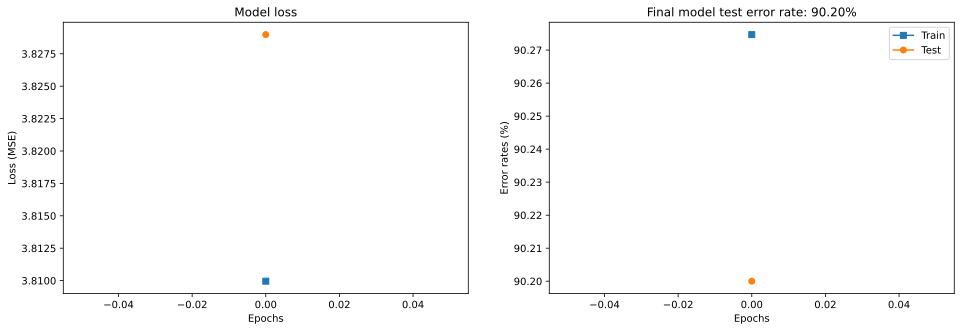

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss_D,'s-',label='Train')
ax[0].plot(testLoss_D,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr_D,'s-',label='Train')
ax[1].plot(testErr_D,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr_D[-1]:.2f}%')
ax[1].legend()

plt.show()

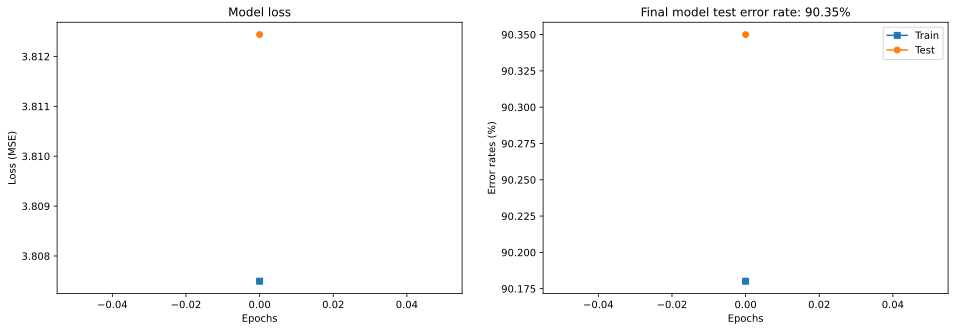

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss_DF,'s-',label='Train')
ax[0].plot(testLoss_DF,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainErr_DF,'s-',label='Train')
ax[1].plot(testErr_DF,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testErr_DF[-1]:.2f}%')
ax[1].legend()

plt.show()

# Accuracy by letter

# Additional explorations

In [ ]:
# 1) I added batch normalization to the convolution layers, but not to the linear (fc*) layers. But linear layers also 
#    benefit from batchnorm just like convolution layers do. Add it!
# 
# 2) In the next few videos, we will see whether we can improve the model's performance by experimenting with the number
#    of layers, kernel size, and linear-layer units. Is there anything you could think of, other than these three features,
#    that might help boost model performance?
# 